In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob, os, json
import time, tqdm

In [17]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 40 images...


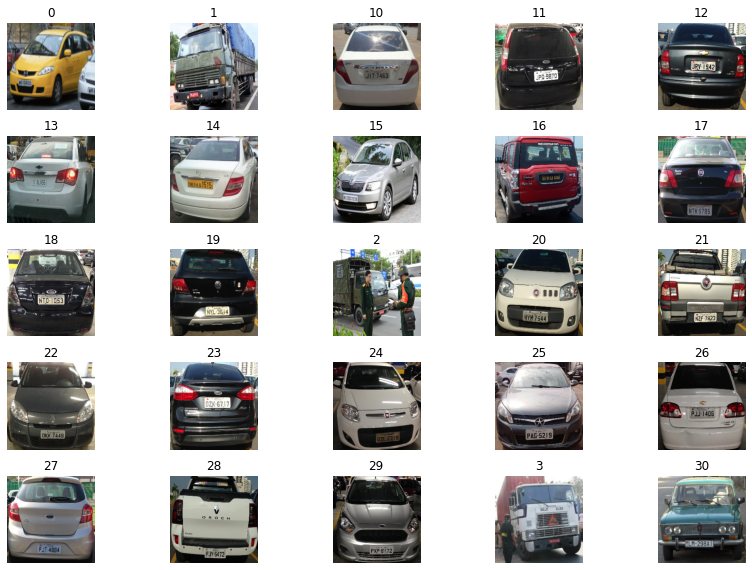

In [18]:
# Create a list of image paths 
image_paths = glob.glob("dataset/original/images/*.png")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 5
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

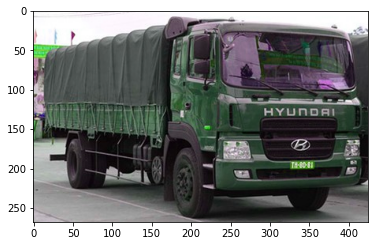

In [7]:
import imgaug.augmenters as iaa
from PIL import Image
aug = iaa.WithColorspace(
    to_colorspace="HSV",
    from_colorspace="RGB",
    children=iaa.WithChannels(
        0,
        iaa.Add((0, 50))
    )
)

image_paths = glob.glob("dataset/original/images/*.png")
for i in range(len(image_paths)):
    c_img = preprocess_image(image_paths[i])
    # c_img = c_img.astype(np.float64)
    c_img = c_img / c_img.max() #normalizes c_img in range 0 - 255
    c_img = 255 * c_img
    c_img = c_img.astype(np.uint8)
    # c_label = labels[i][0]

    for j in range(4):
        image_aug= aug(image=c_img)
        plt.imshow(image_aug)
        Image.fromarray(image_aug).save("dataset/colorspace/images/" + str(i) + "-" + str(j) + ".png")

In [24]:
# Loading json file
path_to_json = 'dataset/colorspace/labels/'
path_to_ground_truth = 'mAP/input/ground-truth/'
labels = []

# delete current ground-truth files
for file_name in os.listdir(path_to_ground_truth):
    os.remove(path_to_ground_truth + file_name)

# update labels and ground-truth
for file_name in os.listdir(path_to_json):
    with open(path_to_json + file_name) as json_file:
        with open(path_to_ground_truth + file_name.split('.')[0] + '.txt', 'w') as txt_file:
            data = json.load(json_file)
            pts = []
            for plate in data['shapes']:
                # make the ground-truth files
                pt = plate['points']
                txt_file.write(f"licenseplate {round(min(pt[0][0],pt[3][0]))} {round(min(pt[0][1],pt[1][1]))} {round(max(pt[1][0],pt[2][0]))} {round(max(pt[2][1],pt[3][1]))}\n")

                pts.append(pt)
            labels.append(pts)

print(labels)

[[[[23.013245033112582, 65.23178807947019], [48.841059602649004, 66.05960264900662], [49.00662251655629, 72.8476821192053], [23.178807947019866, 72.01986754966887]]], [[[23.013245033112582, 65.23178807947019], [48.841059602649004, 66.05960264900662], [49.00662251655629, 72.8476821192053], [23.178807947019866, 72.01986754966887]]], [[[23.013245033112582, 65.23178807947019], [48.841059602649004, 66.05960264900662], [49.00662251655629, 72.8476821192053], [23.178807947019866, 72.01986754966887]]], [[[23.013245033112582, 65.23178807947019], [48.841059602649004, 66.05960264900662], [49.00662251655629, 72.8476821192053], [23.178807947019866, 72.01986754966887]]], [[[114.37699680511183, 279.87220447284346], [164.85623003194888, 276.3578274760383], [166.45367412140575, 293.2907348242812], [115.65495207667732, 297.444089456869]]], [[[114.37699680511183, 279.87220447284346], [164.85623003194888, 276.3578274760383], [166.45367412140575, 293.2907348242812], [115.65495207667732, 297.444089456869]]],

In [9]:
len(labels)

160

In [11]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [12]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


Detect 1 plate(s) in 14-3
Coordinate of plate(s) in image: 
 [array([[340.9842296 , 561.97574964, 561.67805142, 340.68653138],
       [493.27503987, 493.27557688, 565.88123372, 565.8806967 ],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


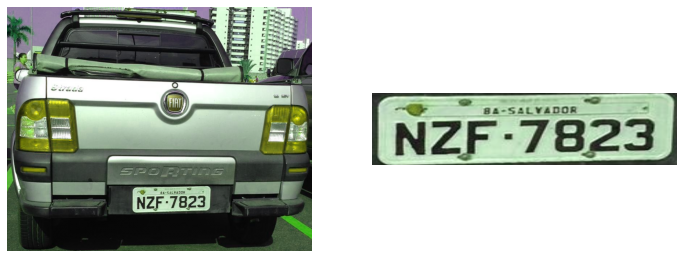

In [25]:
# forward image through model and return plate's image and coordinates
def get_plate(image_path, Dmax=608, Dmin=300, generate_result=True):
    if generate_result:
        res_file_name = image_path[image_path.find('images')+7:].split('.')[0] + '.txt'
        res_file = open(path_to_detection_results + res_file_name, 'w')
    
    vehicle = preprocess_image(image_path)
    #print(f"Shape: {vehicle.shape}")
    H,W = vehicle.shape[:2]
    # print("Height {}, Width {}".format(vehicle.shape[0], vehicle.shape[1]) )
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    L, LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    #print(f"Confidence: {L[0].prob()}")
    #print(L[0].tl(), L[0].br())
    
    if generate_result:
        if L != None:
            for lp in L:
                res_file.write(f"licenseplate {lp.prob()} {round(W*lp.tl()[0])} {round(H*lp.tl()[1])} {round(W*lp.br()[0])} {round(H*lp.br()[1])}\n")
        res_file.close()
        
    else:
        return LpImg, cor

# Obtain plate image and its coordinates from an image
image_paths = glob.glob("dataset/colorspace/images/*.png")
test_image = image_paths[27]
LpImg,cor = get_plate(test_image, generate_result=False)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

#plt.savefig("part1_result.jpg",dpi=300)

In [26]:
path_to_detection_results = 'mAP/input/detection-results/'

# delete current detection-results
for file_name in os.listdir(path_to_detection_results):
    os.remove(path_to_detection_results + file_name)

# create detection-results for our dataset
for image_path in image_paths:
    get_plate(image_path)

No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!
No License plate is founded!


# Calculate IOU - AP - mAP

In [27]:
start = time.time()
os.system('python ./mAP/main.py')
print(f"Time elapsed: {time.time()-start} seconds")

Time elapsed: 13.994154930114746 seconds
